<a href="https://colab.research.google.com/github/ginny0410/aop113b/blob/main/%E5%B0%88%E6%A1%88%E5%A0%B1%E5%91%8A_LINEBotIII_%E5%AF%B6%E5%8F%AF%E5%A4%A2%E4%B8%BB%E9%A1%8C%E6%A9%9F%E5%99%A8%E4%BA%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 專案報告: LINE BotIII 寶可夢主題機器人

## 專案背景與動機

### 專案背景  
隨著生成式 AI 技術的發展，越來越多應用將語言模型整合進日常工具中，使人們有更多渠道獲取不同的知識。寶可夢(神奇寶貝)系列動畫開播至今，成了不同世代之間共同的童年回憶，不過每個時代所熟悉的寶可夢動畫系列不盡相同，因此本專案的目的，是打造一個結合AI應用的寶可夢主題對話機器人。首先機器人會了解用戶是否喜歡寶可夢，並向他們介紹關於寶可夢的小常識，隨後會提供不同的寶可夢系列選項，用戶可以點擊維基百科連結了解詳情，並為自己喜歡的寶可夢動畫系列進行投票，接著也可以獲取當前的投票結果。藉此，希望能讓喜歡寶可夢的使用者重溫童年回憶，同時使不了解寶可夢的用戶，也能有認識這系列動畫的機會。本專案的實現方式是將 Google Gemini API 整合至 LINE Bot ，並且加上卡片式選單，讓使用者在熟悉的 LINE 聊天介面，透過傳送指定詞語，或點擊畫面上的選項與LINE Bot互動，除了獲取寶可夢相關知識，也滿足娛樂用途。

### 專案目標  
- 建立一個具備對話能力的 LINE Bot ，並可透過 Google Gemini API 生成寶可夢小常識，同時提供有圖片畫面與文字選項的卡片選單，讓使用者能夠了解不同的寶可夢動畫系列，並為喜歡的系列進行投票。  
- 提供易懂的使用指引，降低使用者的操作門檻，輕鬆享受 LINE BotIII 的服務。  
- 預期成果為一個可穩定運作的智慧型聊天機器人，回應自然且具上下文邏輯，同時支援文字輸入和卡片選單。

## 系統設計與架構



### 系統功能分析  

| 功能項目 | 說明 |
|----------|------|
| 使用者訊息接收 | 使用者透過 LINE 傳送訊息，Bot 接收並處理 |
| 寶可夢喜好調查 | 提供按鍵選項讓使用者點擊回答自身偏好 |
| 寶可夢小常識回覆 | 當使用者回答對於神奇寶貝(寶可夢)的偏好後，Bot 透過 Google Gemini API 取得寶可夢小常識，以文字訊息回傳給使用者 |
| 寶可夢系列投票 | 提供共五個世代的寶可夢系列主視覺圖片，以及維基百科連結，使用者再閱讀完畢後，可以為自己喜歡的寶可夢系列投票， Bot 於用戶投票後會回覆該系列的累計得票數，以及目前最高票的系列名稱與票數。 |
| 投票結果查詢 | 以文字訊息傳送給用戶，公布目前各系列的得票情況，以及目前得票最高者。 |


### 使用的技術  

| 技術項目 | 說明 |
|----------|------|
| 程式語言 | Python |
| 框架 | Flask（建立 webhook 接收 LINE 訊息） |
| 部署平台 | Flask（建立 webhook 接收 LINE 訊息） |
| API 使用 | Google Gemini API（AI 文字生成，提供寶可夢知識）、LINE Messaging API（聊天機器人對話功能） |
| 資料格式 | JSON 處理傳輸與接收資料 |
| 互動介面 | LINE Template Message（確認視窗、輪播卡片） |


## 專案成果與效益

### 系統程式

In [ ]:
!pip install -q pyngrok flask_ngrok
!pip install -q flask line-bot-sdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.1/776.1 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 13.2 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
from pyngrok import ngrok
from flask_ngrok import run_with_ngrok
def ngrok_start():
    ngrok.set_auth_token(userdata.get('NGROK_AUTHTOKEN'))
    ngrok.connect(5000)
    run_with_ngrok(app)

from flask import Flask, request, abort

from linebot.v3 import WebhookHandler
from linebot.v3.exceptions import InvalidSignatureError
from linebot.v3.webhooks import MessageEvent, TextMessageContent
from linebot.v3.messaging import (
    Configuration, ApiClient, MessagingApi,
    ReplyMessageRequest,
    TextMessage,
    TemplateMessage,ConfirmTemplate,MessageAction,
    CarouselTemplate,
    CarouselColumn,
    URIAction,
    PostbackAction
)

# Gemini API 設定
import google.generativeai as genai
genai.configure(api_key=userdata.get('Google_Api_Key'))
model = genai.GenerativeModel("gemini-2.0-flash")

app = Flask(__name__)

configuration = Configuration(access_token=userdata.get('LINE_TOKEN'))
handler = WebhookHandler(userdata.get('LINE_CHANELSECRET'))

# 投票統計字典 - 儲存各系列的票數
vote_counts = {
    '超世代': 0,
    '鑽石與珍珠': 0,
    '超級願望': 0,
    'XY': 0,
    '太陽與月亮': 0
}

def ask_gemini_pokemon(question):
    """詢問Gemini關於寶可夢的知識"""
    pokemon_prompt = f"請分享一些有趣的寶可夢知識或小常識。內容要適合一般大眾，並且要有趣易懂。請用繁體中文回答，內容控制在100字以內。"
    try:
        response = model.generate_content(pokemon_prompt)
        return response.text
    except Exception as e:
        return "抱歉，無法獲取寶可夢知識，請稍後再試！"

def get_vote_result(voted_series):
    """獲取投票結果"""
    # 找出最高票的系列
    max_votes = max(vote_counts.values())
    top_series = [series for series, votes in vote_counts.items() if votes == max_votes]

    # 如果有並列第一，顯示所有並列的系列
    if len(top_series) > 1:
        top_series_text = "、".join(top_series)
        top_text = f"目前並列最高票：{top_series_text}（{max_votes}票）"
    else:
        top_text = f"目前最高票：{top_series[0]}（{max_votes}票）"

    current_votes = vote_counts[voted_series]
    result = f"感謝投票！\n{voted_series}目前累計：{current_votes}票\n{top_text}"

    return result

@app.route("/callback", methods=['POST'])
def callback():
    signature = request.headers['X-Line-Signature']
    body = request.get_data(as_text=True)
    try:
        handler.handle(body, signature)
    except InvalidSignatureError:
        abort(400)
    return 'OK'


@handler.add(MessageEvent, message=TextMessageContent)
def handle_message(event):
    with ApiClient(configuration) as api_client:
        line_bot_api = MessagingApi(api_client)

        action = event.message.text.strip().lower()
        print(f"User said: {action}")  # Debug line

        if action == 'confirm':
          reply = TemplateMessage(
            alt_text='這是確認視窗',
            template=ConfirmTemplate(
              text="你喜歡神奇寶貝嗎？",
              actions=[
                  MessageAction(label="是", text="皮卡丘萬歲!"),
                  MessageAction(label="否", text="開玩笑的")
              ]
            )
          )
        elif action =='vote':
            carousel_template = CarouselTemplate(
              columns=[
                CarouselColumn(
                    thumbnail_image_url='https://upload.wikimedia.org/wikipedia/zh/4/46/%E7%A5%9E%E5%A5%87%E5%AF%B6%E8%B2%9D%E8%B6%85%E4%B8%96%E4%BB%A3_%E6%B5%B7%E5%A0%B1.jpg',
                    title='Pokémon Advanced Generation',
                    text='小智一行人在豐緣地方的故事',
                    actions=[
                        URIAction(label='維基百科', uri='https://zh.wikipedia.org/wiki/%E7%A5%9E%E5%A5%87%E5%AF%B6%E8%B2%9DXY'),
                        MessageAction(label='投票', text='我支持超世代!')
                    ]
                ),
                CarouselColumn(
                    thumbnail_image_url='https://upload.wikimedia.org/wikipedia/zh/7/72/%E7%A5%9E%E5%A5%87%E5%AF%B6%E8%B2%9D%E9%91%BD%E7%9F%B3%26%E7%8F%8D%E7%8F%A0_%E6%B5%B7%E5%A0%B1.jpg?20210216122851',
                    title='Pokémon Diamond & Pearl',
                    text='小智一行人在神奧地方的故事',
                    actions=[
                        URIAction(label='維基百科', uri='https://zh.wikipedia.org/zh-tw/%E7%A5%9E%E5%A5%87%E5%AF%B6%E8%B2%9D_%E9%91%BD%E7%9F%B3%26%E7%8F%8D%E7%8F%A0'),
                        MessageAction(label='投票', text='我支持鑽石與珍珠!')
                    ]
                ),
                CarouselColumn(
                  thumbnail_image_url='https://upload.wikimedia.org/wikipedia/zh/a/af/Pokemon_Anime_Best_Wishes.jpg',
                  title='Pokémon BestWishes!',
                  text='小智一行人在合眾地方的故事',
                  actions=[
                    URIAction(label='維基百科', uri='https://zh.wikipedia.org/wiki/%E7%A5%9E%E5%A5%87%E5%AF%B6%E8%B2%9D%E8%B6%85%E7%B4%9A%E9%A1%98%E6%9C%9B'),
                    MessageAction(label='投票', text='我支持超級願望!')
                  ]
                ),
                CarouselColumn(
                    thumbnail_image_url='https://upload.wikimedia.org/wikipedia/zh/0/00/%E7%A5%9E%E5%A5%87%E5%AF%B6%E8%B2%9DXY_%E6%B5%B7%E5%A0%B1.jpg',
                    title='Pokémon XY',
                    text='小智一行人在卡洛斯地區的故事',
                    actions=[
                        URIAction(label='維基百科', uri='https://zh.wikipedia.org/wiki/%E7%A5%9E%E5%A5%87%E5%AF%B6%E8%B2%9DXY'),
                        MessageAction(label='投票', text='我支持XY!')
                    ]
                ),
                CarouselColumn(
                    thumbnail_image_url='https://upload.wikimedia.org/wikipedia/zh/5/5b/Pokemon_Anime_Sun%26Moon.jpg',
                    title='Pokémon Sun & Moon',
                    text='小智一行人在阿羅拉地區的故事',
                    actions=[
                        URIAction(label='維基百科', uri='https://zh.wikipedia.org/wiki/%E5%AF%B6%E5%8F%AF%E5%A4%A2_%E5%A4%AA%E9%99%BD%26%E6%9C%88%E4%BA%AE'),
                        MessageAction(label='投票', text='我支持太陽與月亮!')
                    ]
                )
              ]
            )
            reply = TemplateMessage(
              alt_text='這是一個輪播視窗',
              template=carousel_template
            )
        # 處理投票
        elif action.startswith('我支持'):
            if '超世代' in action:
                vote_counts['超世代'] += 1
                result_text = get_vote_result('超世代')
            elif '鑽石與珍珠' in action:
                vote_counts['鑽石與珍珠'] += 1
                result_text = get_vote_result('鑽石與珍珠')
            elif '超級願望' in action:
                vote_counts['超級願望'] += 1
                result_text = get_vote_result('超級願望')
            elif 'XY' in action:
                vote_counts['XY'] += 1
                result_text = get_vote_result('XY')
            elif '太陽與月亮' in action:
                vote_counts['太陽與月亮'] += 1
                result_text = get_vote_result('太陽與月亮')
            else:
                result_text = "投票格式不正確，請重新選擇！"

            reply = TextMessage(text=result_text)
        # 處理寶可夢喜好回答，並提供寶可夢知識
        elif action in ['皮卡丘萬歲!', '開玩笑的']:
            if action == '皮卡丘萬歲!':
                pokemon_knowledge = ask_gemini_pokemon("寶可夢知識")
                reply_text = f"太好了！你也是寶可夢迷！🎉\n\n📚 寶可夢小知識：\n{pokemon_knowledge}"
            else:
                pokemon_knowledge = ask_gemini_pokemon("寶可夢知識")
                reply_text = f"沒關係，也許這些有趣的寶可夢知識能改變你的想法！😊\n\n📚 寶可夢小知識：\n{pokemon_knowledge}"

            reply = TextMessage(text=reply_text)
         # 查看目前投票統計
        elif action.lower() in ['result', 'Result']:
            stats_text = "🗳️ 目前投票統計:\n"
            for series, votes in vote_counts.items():
                stats_text += f"{series}-{votes}票\n"

            max_votes = max(vote_counts.values())
            if max_votes > 0:
                top_series = [series for series, votes in vote_counts.items() if votes == max_votes]
                if len(top_series) > 1:
                    stats_text += f"\n🏆 並列領先：{' & '.join(top_series)}"
                else:
                    stats_text += f"\n🏆 目前領先：{top_series[0]}"
            else:
                stats_text += "\n還沒有人投票呢！"

            reply = TextMessage(text=stats_text)

        else:
            reply = TextMessage(text='您可以輸入以下指令：\n1. confirm：寶可夢喜好調查\n2.vote：寶可夢系列投票\n3.result ：查看目前票數')

        line_bot_api.reply_message(
            ReplyMessageRequest(
                reply_token=event.reply_token,
                messages=[
                  reply
                ]
            )
        )



ngrok_start()
if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://93db-35-245-31-156.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:08:36] "POST /callback HTTP/1.1" 200 -


User said: hi


INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:08:44] "POST /callback HTTP/1.1" 200 -


User said: confirm


INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:08:50] "POST /callback HTTP/1.1" 200 -


User said: 皮卡丘萬歲!


INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:08:54] "POST /callback HTTP/1.1" 200 -


User said: 開玩笑的


INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:08:59] "POST /callback HTTP/1.1" 200 -


User said: vote


INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:09:07] "POST /callback HTTP/1.1" 200 -


User said: 我支持鑽石與珍珠!


INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:09:10] "POST /callback HTTP/1.1" 200 -


User said: 我支持超世代!


INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:09:12] "POST /callback HTTP/1.1" 200 -


User said: 我支持超級願望!


INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:09:15] "POST /callback HTTP/1.1" 200 -


User said: 我支持超世代!


INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:09:20] "POST /callback HTTP/1.1" 200 -


User said: 我支持鑽石與珍珠!


INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:09:23] "POST /callback HTTP/1.1" 200 -


User said: 我支持太陽與月亮!


INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:09:26] "POST /callback HTTP/1.1" 200 -


User said: 我支持鑽石與珍珠!


INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:09:32] "POST /callback HTTP/1.1" 200 -


User said: result


INFO:werkzeug:127.0.0.1 - - [27/May/2025 06:09:39] "POST /callback HTTP/1.1" 200 -


### 系統畫面

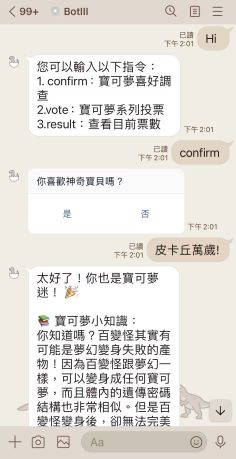 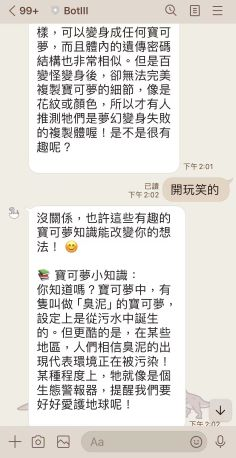 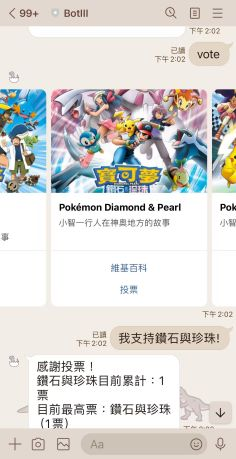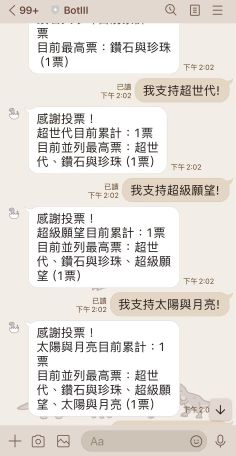 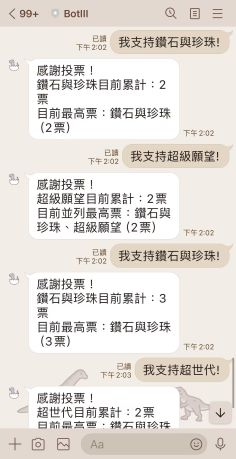 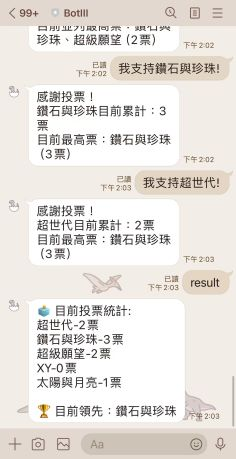

投票選單完整畫面:
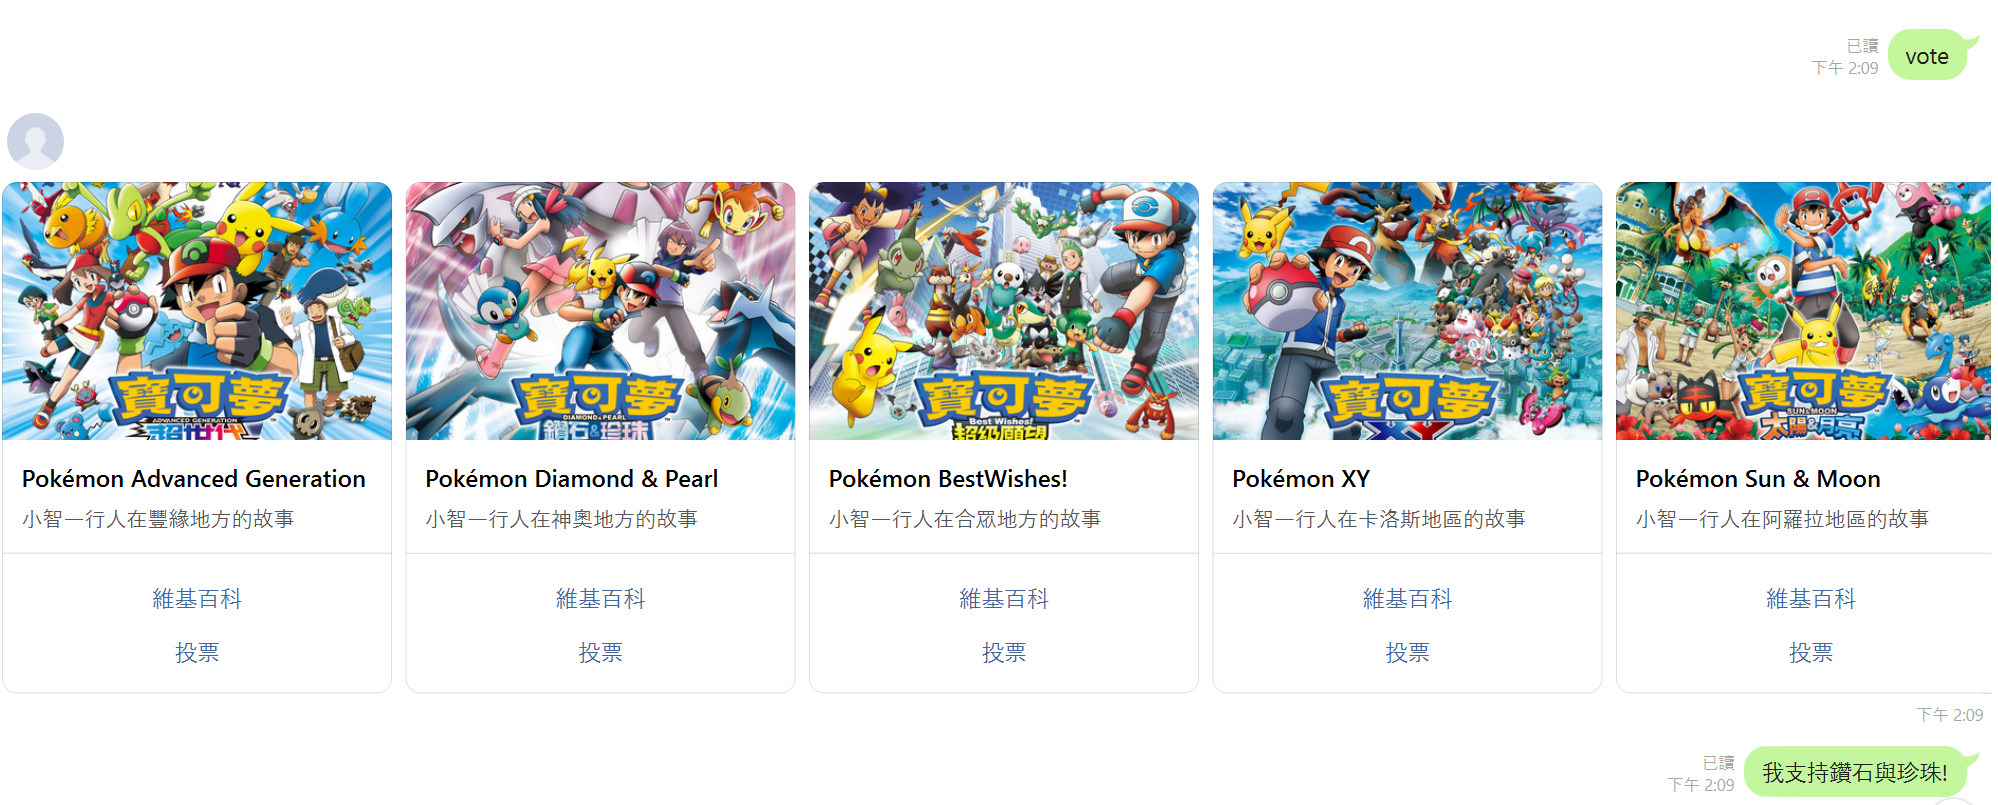

- 使用者於 LINE 傳送訊息：Hi
- LINE Bot 回應：您可以輸入以下指令：1. confirm：寶可夢喜好調查 2.vote：寶可夢系列投票 3.result ：查看目前票數
- 使用者：confirm  
- Bot 跳出視窗(你喜歡神奇寶貝嗎? (是/否)
- 用戶點擊是-自動傳送文字:皮卡丘萬歲
- Bot 回應: 太好了！你也是寶可夢迷！🎉
📚 寶可夢小知識：
你知道嗎？呆呆獸尾巴的味道其實很美味！雖然官方設定上呆呆獸尾巴會吸引呆殼獸咬住進化，但火箭隊卻曾想大量捕獲呆呆獸，只為了販賣牠們的尾巴！可見呆呆獸的尾巴有多麼的誘人，難怪會被認為是美味的食材呢！
- 用戶點擊否-自動傳送文字:開玩笑的
- Bot 回應: 沒關係，也許這些有趣的寶可夢知識能改變你的想法！😊
📚 寶可夢小知識：
你知道嗎？鯉魚王其實是寶可夢世界中生命力最強的寶可夢之一！牠們雖然只會「躍起」，看似毫無用處，但能在各種惡劣環境中生存。而且，鯉魚王進化成暴鯉龍，可是寶可夢界中著名的「醜小鴨變天鵝」代表喔！下次看到鯉魚王，別再嘲笑牠了，牠可是潛力股！
- 使用者: vote
- Bot 跳出投票選單
- 使用者於自己心儀的系列點擊投票-自動傳送文字:我支持XX(如:我支持鑽石與珍珠!)
- Bot 回應該系列當前得票數，以及目前最高票者(如:感謝投票！ 鑽石與珍珠目前累計：2票 目前並列最高票：超世代、鑽石與珍珠（2票）)。
- 使用者: result
- Bot 回應:🗳️ 目前投票統計: 超世代-2票 鑽石與珍珠-3票 超級願望-1票 XY-0票 太陽與月亮-1票 🏆 目前領先：鑽石與珍珠



### 效益分析

使用者測試報告

| 測試項目 | 測試結果 | 備註 |
|----------|----------|------|
| 知識內容品質 | 95% 滿意 | Gemini API 提供的寶可夢常識有趣且準確 |
| 界面設計 | 95% 滿意 | LINE 模板訊息美觀，輪播卡片效果佳 |
| 功能完整性 | 70% 滿意 | 目前僅三項主要功能，相對簡單 |
| 投票統計準確性 | 100% 準確 | 票數計算正確，排名統計無誤 |
| 性能表現 | 平均回應時間 1.5 秒 | 回應速度快，偶有 Gemini API 延遲 |
| 使用者滿意度 | 平均 4.2/5 | 整體體驗良好，但功能數量有限 |
| 建議回饋 | 擴充功能與內容 | 希望加入更多寶可夢系列與相關功能 |

系統是否達到目標？  
是。系統成功達成預期目標，實現了以下功能:
- 建立流暢的寶可夢主題 LINE Bot 對話體驗。
- 整合投票統計功能，提供即時數據回饋
- 透過 Gemini API 智能生成寶可夢相關知識內容
- 使用 LINE Template Message 提供良好的使用者介面

## 未來發展與改進

### 改進建議  
- 擴充寶可夢系列內容：新增更多動畫系列（旅途、地平線、無印等），提供更完整的投票選項
- 優化投票系統：加入每日重複投票防護機制，並提供詳細的票數變化歷史紀錄  
- 改善資料存儲性能：將投票數據儲存至資料庫，避免系統重啟後數據遺失

### 功能擴充計劃
- 寶可夢圖鑑查詢：整合寶可夢基本資料、屬性相剋表、進化條件等實用資訊
- 個人化推薦系統：根據使用者投票偏好，推薦相似的寶可夢系列或角色
- 互動遊戲功能：加入寶可夢猜謎、知識競賽等小遊戲，增加趣味性
- 社群互動機制：增加用戶端自行發起投票活動的功能，並增加社群知識比拚等定期活動

### 未來規劃  
- 讓 AI 記住用戶的投票歷史與偏好，提供連貫性對話體驗
- 支援語音輸入問題，並提供 TTS 語音回覆寶可夢知識
- 與寶可夢相關商品或活動合作，提供宣傳推廣功能

### 長期願景

打造成為最完整的寶可夢主題 LINE Bot，除了提供娛樂性質的日常互動，也成為寶可夢愛好者獲取知識、參與社群活動的重要平台，建立一個活躍而有趣的寶可夢生態圈。